In [2]:
import neurolab as nl
import numpy as np
import numpy.matlib
from neupy import algorithms
import pylab as pl
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import neurolab as nl
import random
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX

#### Задание 1

Построить и обучить сеть прямого распространения с запаздыванием (Focused Time-DelayNeural Network, FTDNN), которая будет аппроксимировать последовательность чисел Вольфа, а также выполнить многошаговый прогноз.

In [3]:
df = pd.read_csv('SN_m_tot_V2.0.csv', sep=';', header=None)

In [4]:
df[:3]

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1


In [5]:
df = df.iloc[:, 0:4]
df = df.drop([2], axis=1)
df.columns = ['Year', 'Month', 'Value']
df.Year = df.Year.astype(str)
df.Month = df.Month.astype(str)
df.index = pd.to_datetime(df.Year + '-' + df.Month)
df.drop(['Year'], axis=1, inplace=True)
df.drop(['Month'], axis=1, inplace=True)

In [6]:
df[:3]

,Value
1749-01-01,96.7
1749-02-01,104.3
1749-03-01,116.7


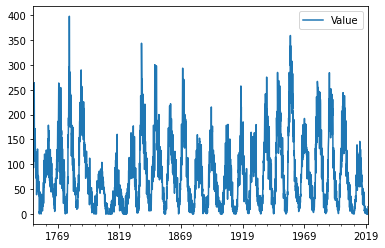

In [7]:
df.plot();

In [8]:
date = '1761-04-01'
deep = 5
trainSize = 500
testSize = 100
validSize = 50

Сглаживание траектории с помощью усредняющего фильтра smooth с шириной окна 12.

In [9]:
def smooth(a, windowWidth):
    # a: NumPy 1-D array containing the data to be smoothed
    # windowWidth: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a, np.ones(windowWidth, dtype=int), 'valid') / windowWidth    
    r = np.arange(1, windowWidth-1,2)
    start = np.cumsum(a[:(windowWidth-1)-1])[::2] / r
    stop = (np.cumsum(a[:-(windowWidth-1):-1])[::2] / r)[::-1]
    return np.concatenate((start, out0, stop))

In [10]:
values = df.values.flatten()
widthWindow = 12
smoothValues = smooth(values, widthWindow)

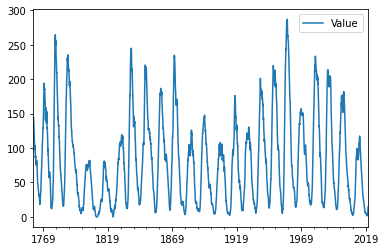

In [11]:
shift = df.values.size - smoothValues.size
df.iloc[shift:] = smoothValues[:, np.newaxis]

df = df[df.index >= pd.to_datetime(date)]
df.plot()

In [12]:
trainSize = int(len(df) * 0.7)
train = df[:trainSize]
test = df[trainSize:]

trainData = train.values.squeeze()
xTrain = np.array([trainData[i:i + deep] for i in range(len(trainData) - deep)])
yTrain = train.iloc[deep:].values

testData = test.values.squeeze()
xTest = np.array([testData[i:i + deep] for i in range(len(testData) - deep)])
yTest = test.iloc[deep:].values

Чисто скрытого слоя 8. Для обучения сети использовать метод Левенберга-Марквардта.

In [13]:
model = Sequential()
model.add(Dense(12, input_dim=deep, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xTrain, yTrain, epochs=60, batch_size=2, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
 - 1s - loss: 454.6764
Epoch 2/60
 - 1s - loss: 25.4498
Epoch 3/60
 - 1s - loss: 21.6197
Epoch 4/60
 - 1s - loss: 20.2646
Epoch 5/60
 - 1s - loss: 19.7097
Epoch 6/60
 - 1s - loss: 18.8690
Epoch 7/60
 - 1s - loss: 18.3623
Epoch 8/60
 - 1s - loss: 17.0596
Epoch 9/60
 - 1s - loss: 17.0399
Epoch 10/60
 - 1s - loss: 15.5171
Epoch 11/60
 - 1s - loss: 16.0332
Epoch 12/60
 - 1s - loss: 14.5403
Epoch 13/60
 - 1s - loss: 14.8246
Epoch 14/60
 - 1s - loss: 13.1405
Epoch 15/60
 - 1s - loss: 12.8737
Epoch 16/60
 - 1s - loss: 12.6553
Epoch 17/60
 - 1s - loss: 12.3570
Epoch 18/60
 - 1s - loss: 11.2183
Epoch 19/60
 - 1s - loss: 11.4498
Epoch 20/60
 - 1s - loss: 11.7041
Epoch 21/60
 - 1s - loss: 11.5920
Epoch 22/60
 - 1s - loss: 10.8487
Epoch 23/60
 - 1s - loss: 11.0494
Epoch 24/60
 - 1s - loss: 11.2526
Epoch 25/60
 - 1s - loss: 10.9032
Epoch 26/60
 - 1s - loss: 11.0589
Epoc

Рассчитать выход сети для обучающего подмножества.

In [15]:
predictTrain = model.predict(xTrain)

In [16]:
MSE = mean_squared_error(yTrain, predictTrain)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 8.210838029299524
RMSE = 2.8654559897683867


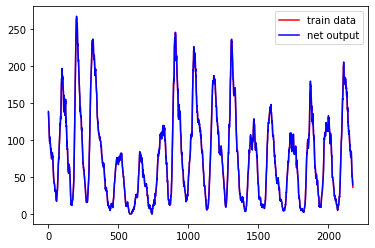

In [17]:
plt.plot(yTrain, color='red')
plt.plot(predictTrain, color='blue')
plt.legend(['train data', 'net output'])
plt.show()

Рассчитать выход сети для тестового подмножества.

In [18]:
predictTest = model.predict(xTest)

In [19]:
MSE = mean_squared_error(yTest, predictTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 7.831346190185805
RMSE = 2.7984542501505727


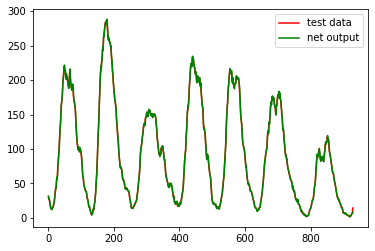

In [20]:
plt.plot(yTest, color='red')
plt.plot(predictTest, color='green')
plt.legend(['test data', 'net output'])
plt.show()

In [21]:
df['pred'] = np.concatenate([df[:deep].values.flatten(), 
                            predictTrain.flatten(),
                            df[trainSize:trainSize+deep].values.flatten(),
                            predictTest.flatten()])

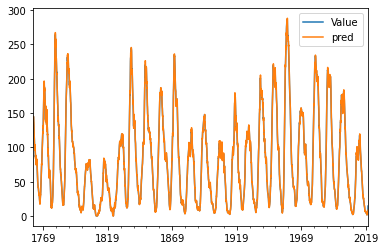

In [22]:
df.plot()

#### Задание 2

Построить  и  обучить  сеть  прямого  распространения  с  распределенным  запаздыванием(Distributed Time-Delay Neural Network, TDNN), которая будет выполнять распознавание динамического образа.

Обучающее множество взять из лабораторной работы №5.

In [23]:
p1_k = np.linspace(0, 1, int(1 / 0.025), endpoint=True)

# Основной сигнал
p1 = np.sin(4 * np.pi * p1_k)

t1 = np.ones(len(p1_k)) * (-1)

p2_k = np.linspace(2.16, 4.04, int(4.04 / 0.025), endpoint=True)

# Сигнал, подлежащий распознаванию
p2 = np.cos(np.cos(p2_k) * p2_k * p2_k + 5 * p2_k)

t2 = np.ones(len(p2_k))

# Длительность основного сигнала
R = np.array([1, 4, 7])

In [24]:
p2 = p2.reshape(1, p2.shape[0])
t2 = t2.reshape(1, t2.shape[0])

In [25]:
P = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, R[2]), p2), axis=1).reshape(-1, 1)

T = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, R[2]), t2), axis=1).reshape(-1, 1)

In [26]:
T = T.reshape(T.shape[0])
P = P.reshape(P.shape[0])

Задать задержки[0 : 4] для входного и скрытого слоев. Число нейронов скрытого слоя задать равным 8. 

In [27]:
# Система с 1 входом и выходом
nn = pyrenn.CreateNN([1, 8, 1], dIn=[4], dIntern=[4])

Обучаем сеть

In [28]:
nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=100)

Maximum number of iterations reached


Рассчитываем выход сети

In [29]:
output = pyrenn.NNOut(P, nn)

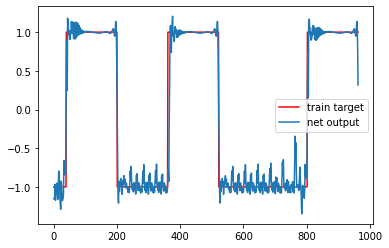

In [30]:
pl.plot(T, color='red')
plt.plot(output)
plt.legend(['train target', 'net output'])
plt.show()

Преобразуем предсказанные значения.

In [31]:
output[output >= 0] = 1.0
output[output < 0] = -1.0

MSE = mean_squared_error(T.reshape(T.shape[0]), output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.020768431983385256
RMSE = 0.14411256705570563


Для проверки качества распознавания сформируем новое обучающее множество, изменив одно из значений R.

In [32]:
p1_k = np.linspace(0, 1, int(1 / 0.025), endpoint=True)

# Основной сигнал
p1 = np.sin(4 * np.pi * p1_k)

t1 = np.ones(len(p1_k)) * (-1)

p2_k = np.linspace(2.16, 4.04, int(4.04 / 0.025), endpoint=True)

# Сигнал, подлежащий распознаванию
p2 = np.cos(np.cos(p2_k) * p2_k * p2_k + 5 * p2_k)

t2 = np.ones(len(p2_k))

# Длительность основного сигнала
R = np.array([1, 4, 12])

In [33]:
p2 = p2.reshape(1, p2.shape[0])
t2 = t2.reshape(1, t2.shape[0])

P2 = np.concatenate((numpy.matlib.repmat(p1, 1, R[0]), p2,
                    numpy.matlib.repmat(p1, 1, R[1]), p2,
                    numpy.matlib.repmat(p1, 1, R[2]), p2), axis=1).reshape(-1, 1)

T2 = np.concatenate((numpy.matlib.repmat(t1, 1, R[0]), t2,
                    numpy.matlib.repmat(t1, 1, R[1]), t2,
                    numpy.matlib.repmat(t1, 1, R[2]), t2), axis=1).reshape(-1, 1)

In [34]:
T2 = T2.reshape(T2.shape[0])
P2 = P2.reshape(P2.shape[0])

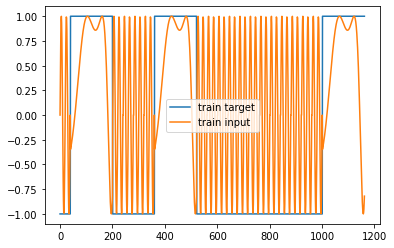

In [35]:
pl.plot(T2)
pl.plot(P2)
pl.legend(['train target', 'train input'])
pl.show()

Рассчитываем выход сети

In [36]:
# Simulate network
output2 = pyrenn.NNOut(P2, nn)

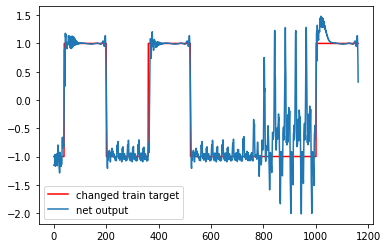

In [37]:
pl.plot(T2, color='red')
pl.plot(output2)
pl.legend(['changed train target', 'net output'])
pl.show()

In [38]:
output2[output2 >= 0] = 1.0
output2[output2 < 0] = -1.0

MSE = mean_squared_error(T2, output2)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.10662080825451418
RMSE = 0.32652841875480637


#### Задание 3

Построить и обучить нелинейную авторегрессионную сеть с внешними входами (Non-linearAutoRegressive network with eXogeneous inputs, NARX), которая будет выполнять аппроксимациютраектории динамической системы, также выполнить многошаговый прогноз значений системы.

Входная последовательность формируется из входного управяющего сигнала u(k) и выходного сигнала y(k). Последовательность целевых выходов задает выходной сигнал y(k). 

In [39]:
def u(k):
    return np.sin(k * k - 10 * k + 3)

k = np.linspace(0, 10, (int)(10/0.01))

y = [0.]
for i in k:
    y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
y = np.array(y[:-1])

Обучающее, тестовое и валидационное множество - число временных отсчетов 700, 200 и 97 соответственно.

In [40]:
delay = 3
trainSize = 700
testSize = 200
validSize = 97
shift=10

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]

Число скрытого слоя 10. Одношаговый прогноз. Сеть имеет 2 выхода.

In [41]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[2], exog_delay=[1])

In [42]:
input = u(k)[:, np.newaxis]
target = y
narx.fit(input, target)

Рассчитаем выход сети

In [43]:
output = narx.predict(input, target, step=1)

In [44]:
output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.00010975944844669733
RMSE = 0.010476614359930279


Сравним выход сети с соответствующими эталонными подмножествами

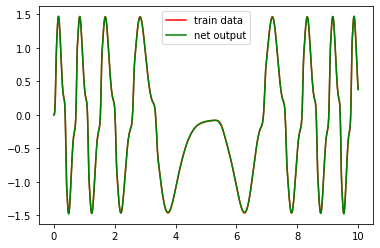

In [45]:
pl.plot(k, y, color='red')
plt.plot(k, output, color='green')
plt.legend(['train data', 'net output'])
plt.show()

Выполним многошаговый прогноз: рассчитаем выход сети для тестового подмножества. 

In [46]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[3], exog_delay=[3])
narx.fit(input, target)

Рассчитаем выход сети

In [47]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
outputTest = narx.predict(inputTest, targetTest, step=3)

In [48]:
outputTest[np.isnan(outputTest)] = 0
MSE = mean_squared_error(targetTest, outputTest)
print('MSE = {}'.format(MSE))
print('RMSE = {}'.format(np.sqrt(MSE)))

MSE = 0.04766468352839287
RMSE = 0.2183224301999061


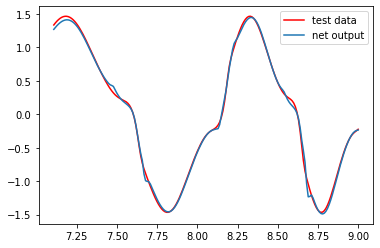

In [49]:
pl.plot(xTest[shift:], yTest[shift:], color='red')
plt.plot(xTest[shift:], outputTest[shift:])
plt.legend(['test data', 'net output'])
plt.show()